<h1><font color = blue>What is our idea

The nucleus is an organelle present within all eukaryotic cells, including human cells. Abberant nuclear shape can be used to identify cancer cells (e.g. pap smear tests and the diagnosis of cervical cancer). Likewise, a growing body of literature suggests that there is some connection between the shape of the nucleus and human disease states such as cancer and aging. As such, the quantitative assessment of nuclear size and shape has important biomedical applications. Methods for assessing nuclear size and shape typically involve identifying the nucleus via traditional image segmentation approaches. Here we demonstrate a deep learning approach for the identification and segmentation of nuclei from images of cells.

* Background: We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Identifying the cells’ nuclei is the starting point for most diseases analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell.<br>
* Motivation: By far, success rates of the CNN methods (without any split), which based on mainstream deep learning structure, can be over 95% on the benefit of the development of the convolutional neural network technology, and this is different from the traditional machine learning methods.<br>
* Our Approach: Convolution Neural Network (CNN), focusing on end-to-end routine, which is: Inputting the whole image, and this is much more common-use.

<h4>Methods</h4>
We use __CNN__ as our main approach to do our project. In machine learning, CNN is a class of deep, feed-forward artificial neural network that has successfully been applied to analyzing visual imagery. CNNs use a variation of multilayer perceptrons designed to require minimal preprocessing. They are also known as shift invariant or space invariant artificial neural networks, based on their shared-weights architecture and translation invariance characteristics.


<div class="alert alert-block alert-success"><h2>Running Python in Jupyter Notebook</h2>
Python is an interpreted high-level programming language for general-purpose programming.<br>
To install Python and get tutorials, pelase visit their  _[OFFICIAL SITE](https://www.python.org/)_<br>
Or you can also browse the tutorial site _[Lynda.com](https://lynda.com/), they have many fabulous crouses on the site<br><br>
 
__Jupyter Notebook__ is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. It is the most popular tool to run Python on.<br>

To have jupyter notebook up and run, please install the IDE Anaconda first.<br>
Or refer to https://github.com/nikbearbrown/INFO_7390/blob/master/Week_1/NBB_Intro_Python.ipynb

<div class="alert alert-block alert-info">** Before running the code, please install "tensorflow_base", "keras","tqdm","tensorflow" module through pip <br>
You can simple do it by typping "pip install "tensorflow_base","pip install keras","pip install tqdm", "pip install tensorflow" in the Anaconda Prompt
Or maybe using the Environments in the Anaconda navigator**

## <font color = blue>Explore Data<br/>

Image segmentation can easily be performed via the use of the Python library OpenCV, but we want to use deep learning to develop an even more accurate result. Below is an implementation of an OpenCV image segmentation task using the same images of nuclei in cells.

In [1]:
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'
FIG_SIZE = (20, 30)

In [2]:
import math
import itertools
import os
import numpy as np
import skimage.io as io
import pandas as pd
from scipy import ndimage
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [3]:
def hsv_to_rgb(h, s, v):
    h -= math.floor(h)
    h = h * 6
    if h < 1:
        [r, g, b] = [1, h, 0]
    elif h < 2:
        [r, g, b] = [2 - h, 1, 0]
    elif h < 3:
        [r, g, b] = [0, 1, h - 2]
    elif h < 4:
        [r, g, b] = [0, 4 - h, 1]
    elif h < 5:
        [r, g, b] = [h - 4, 0, 1]
    else:
        [r, g, b] = [1, 0, 6 - h]
    return [((r - 0.5) * s + 0.5) * v, ((g - 0.5) * s + 0.5) * v, ((b - 0.5) * s + 0.5) * v]

hash_colorize = np.array([[0, 0, 0] if i == 0 else
                              hsv_to_rgb(((i + 1) % 17)/17,
                                         ((i + 1) % 3)/3 / 2 + 0.5,
                                         ((i + 1) % 5)/5 * 2/3 + 1/3)
                          for i in range(256)])

def mask_to_edges(mask):
    mask_edges = np.zeros(mask.shape).astype(np.uint8)
    for ii in range(1, mask.max() + 1):
        submask = mask.copy()
        submask[submask != ii] = 0
        submask[submask == ii] = 1
        submask_edges = submask - ndimage.binary_erosion(submask, structure=np.ones((5,5)))
        mask_edges += submask_edges * ii
    return mask_edges

def visualize_mask(mask, img=None, edges=True, fill=True):
    if fill:
        if img is None:
            img = mask.copy()
            img[img > 0] = 1
        img = np.multiply(np.repeat(np.reshape(img, img.shape + (1,)), 3, 2), hash_colorize[mask])
    else:
        if img is None:
            img = np.zeros(mask.shape)
        img = np.repeat(np.reshape(img, img.shape + (1,)), 3, 2)
    if edges:
        img = np.clip(img + hash_colorize[mask_to_edges(mask)], 0, 1)
    return img

In [4]:
def remove_alpha(img):
    return img[:, :, 0:3]

def grayscale(img):
    if img.shape[2] == 4:
        img = remove_alpha(img)
    return img.mean(axis=2)

def normalize(img):
    if len(img.shape) == 3 and img.shape[2] == 4:
        img = remove_alpha(img)
    img_max = img.max()
    img_min = img.min()
    img = (img - img_min) / (img_max - img_min)
    return img

def flatten_masks(masks):
    mask = np.zeros(masks[0].shape).astype(np.uint8)
    for ii, submask in enumerate(masks, 1):
        submask[submask > 0] = 1
        mask += submask * ii
    return mask

class NucleiDataset():
    def __init__(self, path, transform = None):
        self.path = path
        self.transform = transform
        self.ids = next(os.walk(path))[1]

    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id = self.ids[idx]
        return self.get(id)
    
    def get(self, id):
        path = self.path + id
        image = io.imread(path + "/images/" + id + ".png")
        masks = []
        mask_path = path + "/masks/"
        for mask in next(os.walk(mask_path))[2]:
            masks.append(io.imread(mask_path + mask))
        sample = {"id": id, "image": image, "masks": masks}
        if self.transform:
            self.transform(sample)
        return sample        

def normalize_and_flatten(sample):
    sample["image"] = normalize(grayscale(sample["image"]))
    sample["mask"] = flatten_masks(sample["masks"])
    del sample["masks"]

train_set = NucleiDataset(TRAIN_PATH)
test_set = NucleiDataset(TEST_PATH)

In [5]:
def plot_image(fig, sample, plot_spec):
    image = sample["image"]

    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=plot_spec, wspace=0.1, hspace=0.1)
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j == 0:
            ax.imshow(normalize(image))
        else:
            ax.imshow(visualize_mask(flatten_masks(sample["masks"]), img=normalize(grayscale(image))))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)


These are the smallest (left) and largest (right) samples (measured by area) in the training set. Note that despite the fact that the sample on the right is much higher resolution and so is scaled down, the cell nuclei still appear about the same size, meaning that the nuclei are (in pixel terms) quite a bit larger.

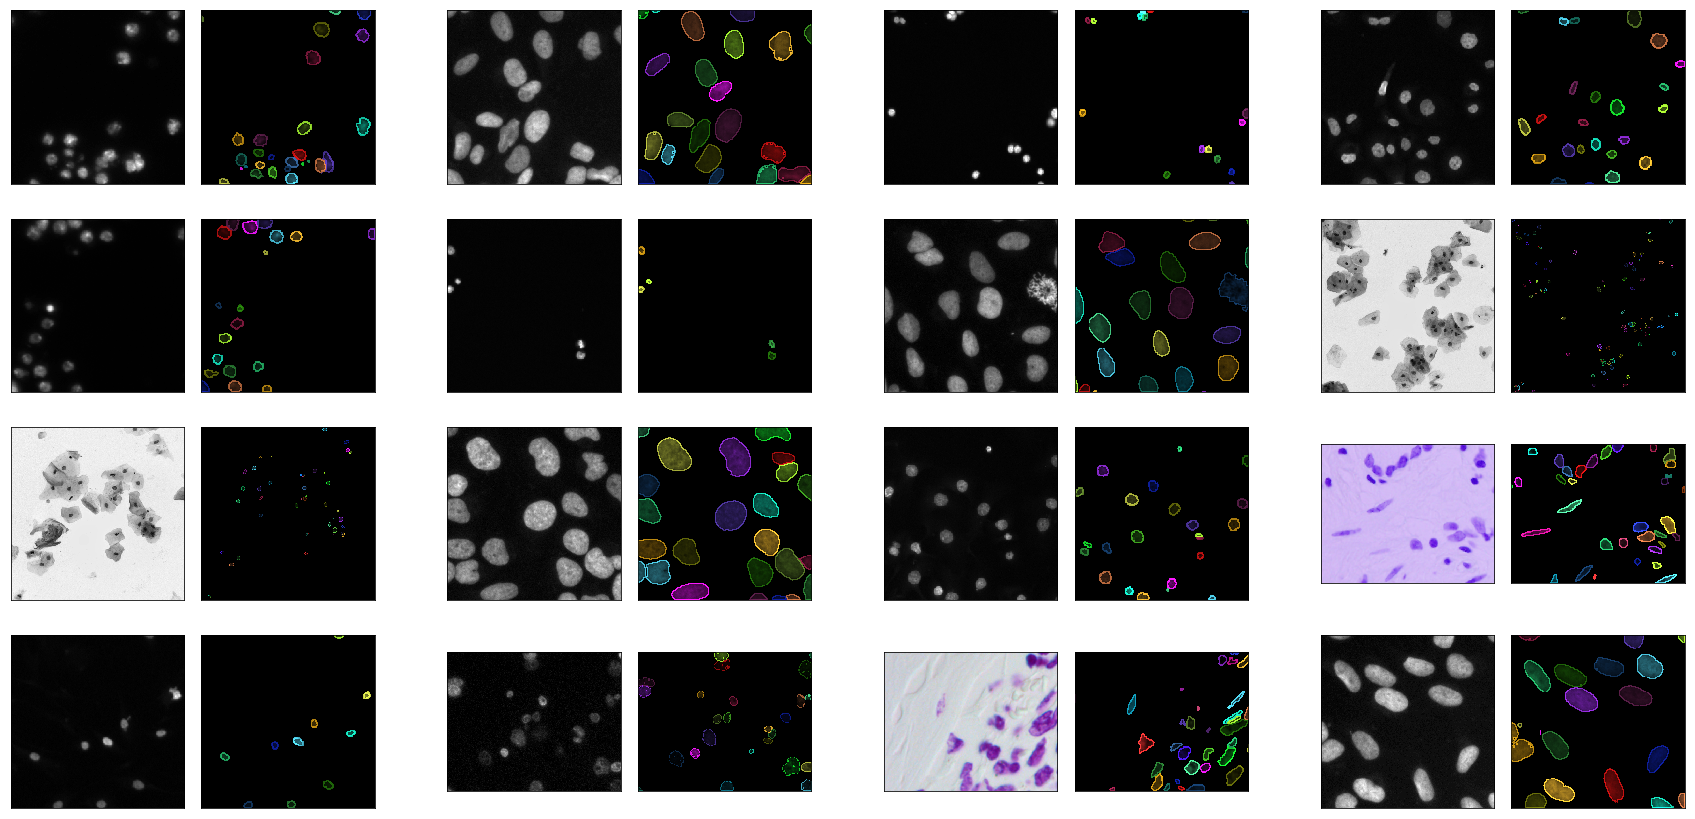

In [6]:
fig = plt.figure(figsize=(FIG_SIZE[1], FIG_SIZE[1]))
outer = gridspec.GridSpec(8, 4, wspace=0.2, hspace=0.2)

for (i, sample) in enumerate(itertools.islice(train_set, 16)):
    plot_image(fig, sample, outer[i])

In [7]:
image_ids = []
image_sizes = []
for sample in train_set:
    image = sample["image"]
    image_ids.append(sample["id"])
    image_sizes.append([image.shape[1], image.shape[0]])
image_ids = np.array(image_ids)
image_sizes = np.array(image_sizes)

In [8]:
images = np.rec.fromarrays((image_ids, image_sizes[:, 0], image_sizes[:, 1]),
                           dtype=[('id', image_ids.dtype), ('w', int), ('h', int)])
pd.DataFrame.from_records(images, index=('id')).head()

,w,h
id,,
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552,256,256
02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339,360,360
03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776,256,256
05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13,256,256
06350c7cc618be442c15706db7a68e91f313758d224de4608f9b960106d4f9ca,256,256


In [9]:
print("Range: (%d - %d) x (%d - %d)" % (images.w.min(), images.w.max(), images.h.min(), images.h.max()))
print("Mean: %d x %d" % (images.w.mean(), images.h.mean()))
aspect_ratio = images.w / images.h
def aspect_ratio_to_str(ratio):
    if ratio >= 1:
        return "%f : 1" % (ratio,)
    else:
        return "1 : %f" % (1 / ratio,)
print("Aspect ratio range: (%s) - (%s)" % (aspect_ratio_to_str(aspect_ratio.min()), aspect_ratio_to_str(aspect_ratio.max())))

Range: (256 - 1388) x (256 - 1040)
Mean: 370 x 327
Aspect ratio range: (1.000000 : 1) - (2.109453 : 1)



These are the smallest (left) and largest (right) samples (measured by area) in the training set. Note that despite the fact that the sample on the right is much higher resolution and so is scaled down, the cell nuclei still appear about the same size, meaning that the nuclei are (in pixel terms) quite a bit larger.

smallest_image:  00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552
biggest_image:  c901794d1a421d52e5734500c0a2a8ca84651fb93b19cec2f411855e70cae339


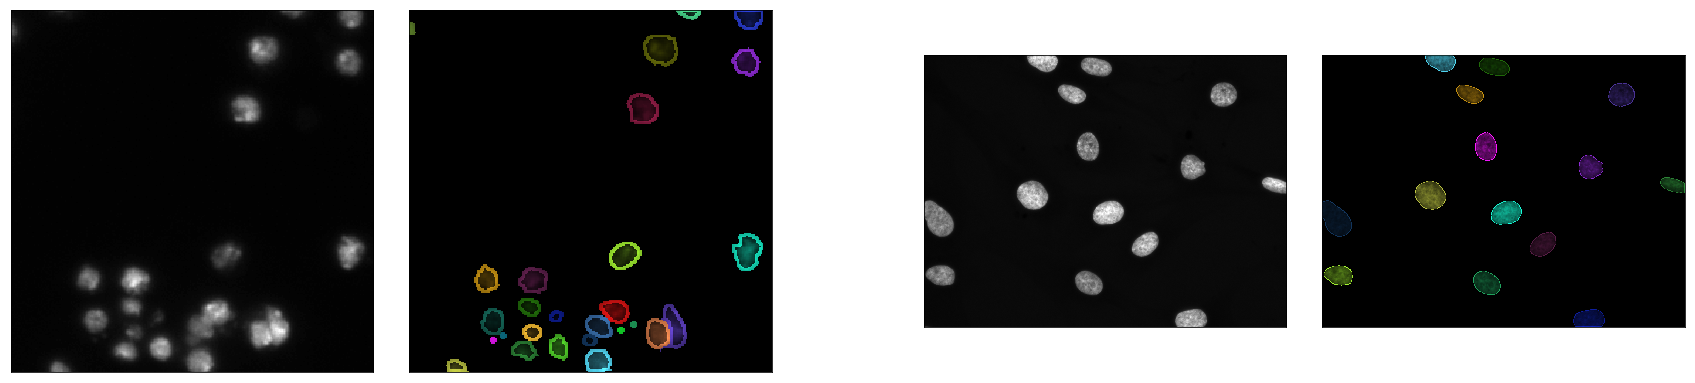

In [10]:
fig = plt.figure(figsize=(FIG_SIZE[1], FIG_SIZE[1]))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

smallest_image = images[(images.w * images.h).argmin()]
biggest_image = images[(images.w * images.h).argmax()]

print("smallest_image: ", smallest_image.id)
print("biggest_image: ", biggest_image.id)

plot_image(fig, train_set.get(smallest_image.id), outer[0])
plot_image(fig, train_set.get(biggest_image.id), outer[1])

lowest_aspect_image:  ('00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552', 256, 256)
highest_aspect_image:  ('a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288', 1272, 603)


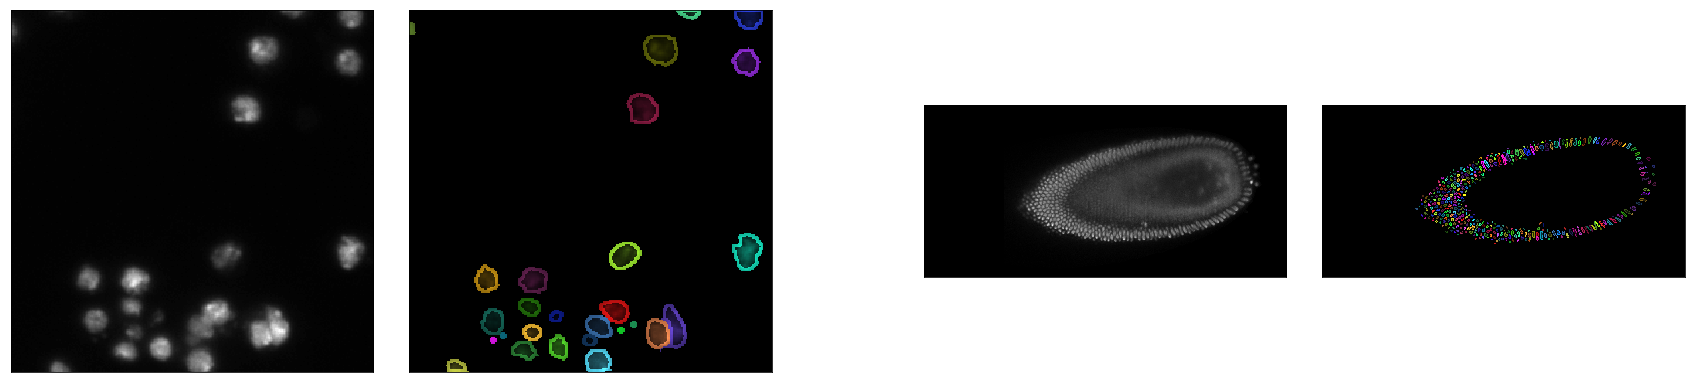

In [11]:
fig = plt.figure(figsize=(FIG_SIZE[1], FIG_SIZE[1]))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

lowest_aspect_image = images[(images.w / images.h).argmin()]
highest_aspect_image = images[(images.w / images.h).argmax()]

print("lowest_aspect_image: ", lowest_aspect_image)
print("highest_aspect_image: ", highest_aspect_image)

plot_image(fig, train_set.get(lowest_aspect_image.id), outer[0])
plot_image(fig, train_set.get(highest_aspect_image.id), outer[1])

In [12]:
mask_ids = []
mask_idcs = []
mask_bounds = []
mask_pixel_counts = []
mask_overlap_counts = []
for sample in train_set:
    image = sample["image"]
    accumulated_mask = np.zeros(image.shape[0:len(image.shape)-1])
    for (mask_idx, mask) in enumerate(sample["masks"]):
        mask_ids.append(sample["id"])
        mask_idcs.append(mask_idx)
        x_positions = np.any(mask, axis=0).nonzero()[0]
        y_positions = np.any(mask, axis=1).nonzero()[0]
        mask_bounds.append([int(x_positions.min()), int(y_positions.min()), int(x_positions.max()), int(y_positions.max())])
        mask_pixel_counts.append(int(np.count_nonzero(mask)))
        mask_overlap_counts.append(int(np.count_nonzero(accumulated_mask * mask)))
        accumulated_mask += mask

Cell Nuclei Sizes
The table below shows, for each sample and each cell nucleus mask in that sample, the bounding box of the nucleus, the count of pixels in the mask, and hence the width, height, area, density and overlap with other masks.

In [13]:
mask_ids = np.array(mask_ids)
mask_idcs = np.array(mask_idcs)
mask_bounds = np.array(mask_bounds)
mask_pixel_counts = np.array(mask_pixel_counts)
mask_overlap_counts = np.array(mask_overlap_counts)
width = mask_bounds[:, 2] - mask_bounds[:, 0] + 1
height = mask_bounds[:, 3] - mask_bounds[:, 1] + 1
area = width * height
density = mask_pixel_counts / area
masks = np.rec.fromarrays((mask_ids, mask_idcs, mask_bounds[:, 0], mask_bounds[:, 1], mask_bounds[:, 2], mask_bounds[:, 3], mask_pixel_counts, width, height, area, density, mask_overlap_counts),
                          dtype=[('id', mask_ids.dtype), ('mask', int), ('x1', int), ('y1', int), ('x2', int), ('y2', int), ('count', int), ('w', int), ('h', int), ('area', int), ('density', float), ('overlap', int)])
pd.DataFrame.from_records(masks, index=('id', 'mask')).head()

x1   y1   x2   y2  \
id                                                 mask                       
00071198d059ba7f5914a526d124d28e6d010c92466da21... 0      46  180   63  199   
                                                   1      26  247   41  255   
                                                   2     141  164  163  183   
                                                   3      77  204   92  216   
                                                   4      72  234   91  247   

                                                         count   w   h  area  \
id                                                 mask                        
00071198d059ba7f5914a526d124d28e6d010c92466da21... 0       259  18  20   360   
                                                   1       112  16   9   144   
                                                   2       353  23  20   460   
                                                   3       174  16  13   208   
                                                   4       198  20  14   280   

                                                          density  overlap  
id                                                 mask                     
00071198d059ba7f5914a526d124d28e6d010c92466da21... 0     0.719444        0  
                                                   1     0.777778        0  
                                                   2     0.767391        0  
                                                   3     0.836538        0  
                                                   4     0.707143        0

In [14]:
print("Range: (%d - %d) x (%d - %d)" % (masks.w.min(), masks.w.max(), masks.h.min(), masks.h.max()))
print("Mean: %d x %d" % (masks.w.mean(), masks.h.mean()))
aspect_ratio = masks.w / masks.h
def aspect_ratio_to_str(ratio):
    if ratio >= 1:
        return "%f : 1" % (ratio,)
    else:
        return "1 : %f" % (1 / ratio,)
print("Aspect ratio range: (%s) - (%s)" % (aspect_ratio_to_str(aspect_ratio.min()), aspect_ratio_to_str(aspect_ratio.max())))
print("Mean density within bounds: %f%%" % (100. * masks.count.sum() / (masks.w * masks.h).sum(),))
print("Mean density across all pixels: %f%%" % (100. * masks.count.sum() / (images.w * images.h).sum(),))
print("Total mask overlap: %d" % (masks.overlap.sum()))

Range: (1 - 122) x (2 - 139)
Mean: 22 x 22
Aspect ratio range: (1 : 57.000000) - (23.500000 : 1)
Mean density within bounds: 71.879001%
Mean density across all pixels: 13.291291%
Total mask overlap: 0


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join
import glob
import sys
import random
import warnings
from tqdm import tqdm
import itertools
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

# Remember to enable GPU
%matplotlib inline


F:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h1><font color = blue>Training the model 

In [16]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('\nx_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

Getting and resizing train images and masks ... 


100%|██████████| 350/350 [01:08<00:00,  5.14it/s]


Getting and resizing test images ... 


100%|██████████| 65/65 [00:01<00:00, 40.83it/s]


Done!

x_train (280, 128, 128, 3)
x_test (70, 128, 128, 3)
y_train (280, 128, 128, 1)
y_test (70, 128, 128, 1)


## <font color = blue>Visualize Training Data 

F:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


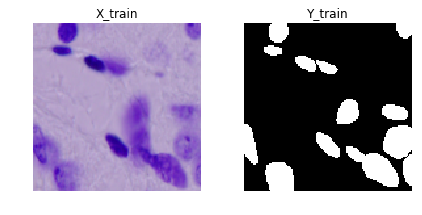

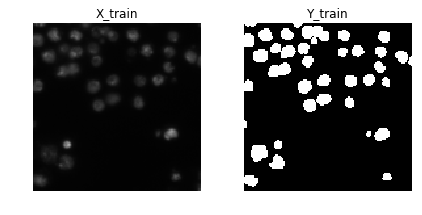

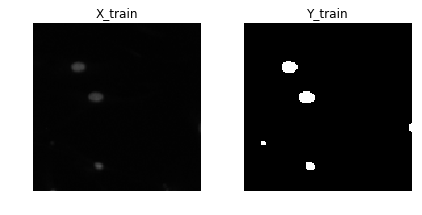

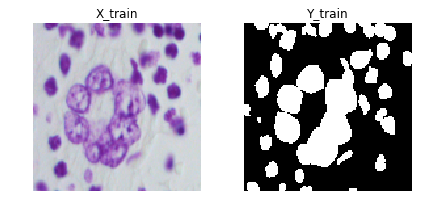

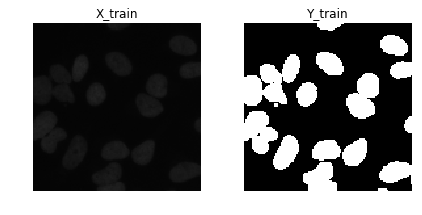

In [17]:
def plotTrainData(a,b):
    for i in range(5):
        ix = random.randint(0, len(train_ids))
        plt.subplot(1,2,1)
        plt.title("X_train")
        imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("Y_train")
        imshow(np.squeeze(b[ix]))
        plt.axis('off')
        plt.show()
plotTrainData(X_train,Y_train)

## configuration <br>
* Configuration of the CNN model<br>
* We get the parameters of the model from open source <br>
* The model will have 7 convolution layers and one fully connected layer

In [18]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#RLE encoding for submission
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

## <font color = blue>Evaluate Convolutional Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    528       
__________

Epoch 00014: val_loss improved from -0.57440 to -0.57703, saving model to model-dsbowl2018-1.h5
Epoch 15/30
280/280 [==============================] - ETA: 22s - loss: -0.6877 - dice_coef: 0.6877 - acc: 0.8879 - mean_squared_error: 0.10 - ETA: 20s - loss: -0.6165 - dice_coef: 0.6165 - acc: 0.8211 - mean_squared_error: 0.17 - ETA: 17s - loss: -0.6180 - dice_coef: 0.6180 - acc: 0.8353 - mean_squared_error: 0.16 - ETA: 14s - loss: -0.5850 - dice_coef: 0.5850 - acc: 0.8126 - mean_squared_error: 0.18 - ETA: 11s - loss: -0.5859 - dice_coef: 0.5859 - acc: 0.8137 - mean_squared_error: 0.18 - ETA: 8s - loss: -0.5714 - dice_coef: 0.5714 - acc: 0.8055 - mean_squared_error: 0.1912 - ETA: 5s - loss: -0.5786 - dice_coef: 0.5786 - acc: 0.8123 - mean_squared_error: 0.184 - ETA: 2s - loss: -0.5632 - dice_coef: 0.5632 - acc: 0.8063 - mean_squared_error: 0.190 - 29s 103ms/step - loss: -0.5702 - dice_coef: 0.5702 - acc: 0.8122 - mean_squared_error: 0.1845 - val_loss: -0.5853 - val_dice_coef: 0.5853 - val_


Epoch 00022: val_loss improved from -0.59659 to -0.60340, saving model to model-dsbowl2018-1.h5
Epoch 23/30
280/280 [==============================] - ETA: 23s - loss: -0.5244 - dice_coef: 0.5244 - acc: 0.7623 - mean_squared_error: 0.23 - ETA: 20s - loss: -0.5484 - dice_coef: 0.5484 - acc: 0.7980 - mean_squared_error: 0.19 - ETA: 16s - loss: -0.6027 - dice_coef: 0.6027 - acc: 0.8234 - mean_squared_error: 0.17 - ETA: 14s - loss: -0.6095 - dice_coef: 0.6095 - acc: 0.8326 - mean_squared_error: 0.16 - ETA: 11s - loss: -0.6029 - dice_coef: 0.6029 - acc: 0.8337 - mean_squared_error: 0.15 - ETA: 8s - loss: -0.5958 - dice_coef: 0.5958 - acc: 0.8253 - mean_squared_error: 0.1683 - ETA: 5s - loss: -0.5892 - dice_coef: 0.5892 - acc: 0.8223 - mean_squared_error: 0.171 - ETA: 2s - loss: -0.5781 - dice_coef: 0.5781 - acc: 0.8156 - mean_squared_error: 0.179 - 29s 102ms/step - loss: -0.5825 - dice_coef: 0.5825 - acc: 0.8166 - mean_squared_error: 0.1783 - val_loss: -0.5960 - val_dice_coef: 0.5960 - val


Epoch 00030: val_loss improved from -0.63345 to -0.68624, saving model to model-dsbowl2018-1.h5


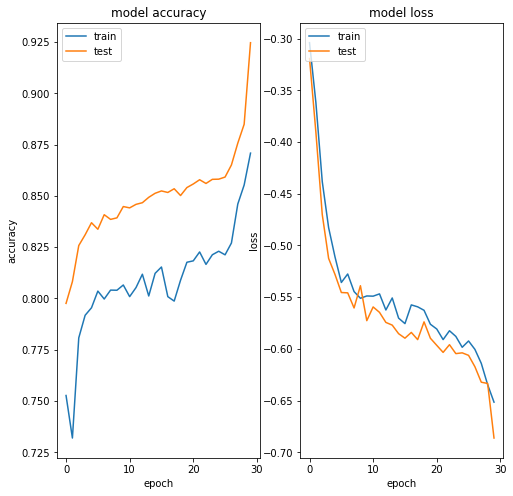

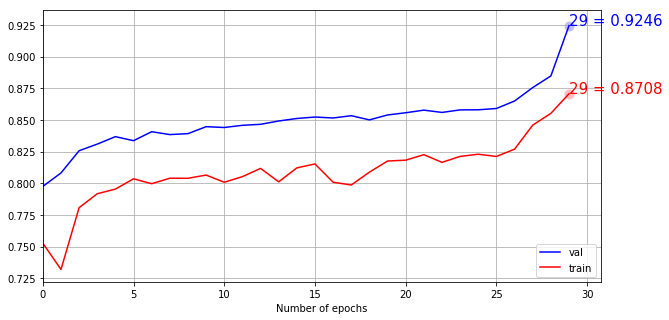

In [19]:
def SIMPLE(a,b,c,d):
    smooth = 1.
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    simple_cnn = Sequential()
    simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS),name = 'NormalizeInput'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    # use dilations to get a slightly larger field of view
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
    # the final processing
    simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
    simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
    simple_cnn.summary()
    checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(patience=5, verbose=1)
    simple_cnn.compile(optimizer = 'adam', 
                       loss = dice_coef_loss, 
                       metrics = [dice_coef, 'acc', 'mse'])
    history = simple_cnn.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks = [earlystopper, checkpointer, MetricsCheckpoint('logs')],epochs = 30)
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    global modelY
    modelY = simple_cnn
    return modelY
SIMPLE(x_train, y_train,x_test,y_test)

Conclusion:
    We can see the plot, the train curve has the accurate is 0.8708. the val curve has the accurate is 0.8708.

70/70 [==============================] - ETA:  - ETA:  - 3s 37ms/step


F:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


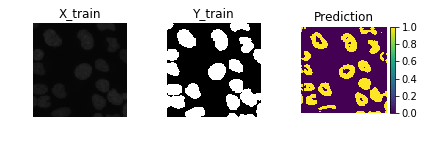

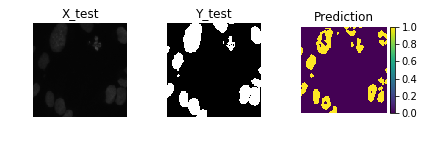

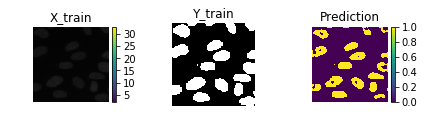

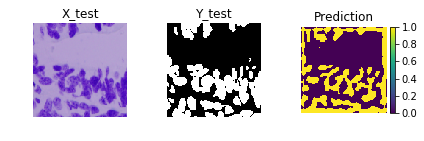

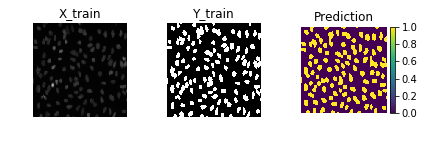

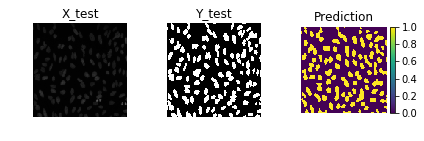

In [20]:
def plotPredictions(a,b,c,d,e):
    model = e
    # Threshold predictions
    preds_train = model.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    for i in range(0, 3):
        # Perform a sanity check on some random training samples
        ix = random.randint(0, len(preds_train_t))
        plt.subplot(1,3,1)
        plt.title("X_train")
        plt.axis('off')
        imshow(a[ix])
        plt.subplot(1,3,2)
        plt.title("Y_train")
        plt.axis('off')
        imshow(np.squeeze(b[ix]))
        plt.subplot(1,3,3)
        plt.title("Prediction")
        plt.axis('off')
        imshow(np.squeeze(preds_train_t[ix]))
        plt.show()
        # Perform a sanity check on some random validation samples
        ix = random.randint(0, len(preds_val_t))
        plt.subplot(1,3,1)
        plt.title("X_test")
        plt.axis('off')
        imshow(a[int(a.shape[0]*0.9):][ix])
        plt.subplot(1,3,2)
        plt.title("Y_test")
        plt.axis('off')
        imshow(np.squeeze(b[int(b.shape[0]*0.9):][ix]))
        plt.subplot(1,3,3)
        plt.title("Prediction")
        plt.axis('off')
        imshow(np.squeeze(preds_val_t[ix]))
        plt.show()
plotPredictions(x_train,y_train,x_test,y_test,modelY)

In [21]:
def plotTestData(a,b):
    for i in range(5):
        ix = random.randint(0, len(sizes_test))
        plt.subplot(1,2,1)
        plt.title("X_train")
        imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("Y_train")
        imshow(np.squeeze(b[ix]))
        plt.axis('off')
        plt.show()

In [22]:
pred_y_test1 = modelY.predict(X_test)

F:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


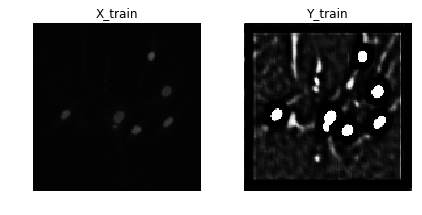

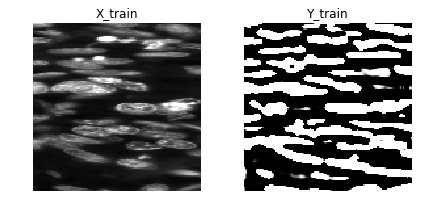

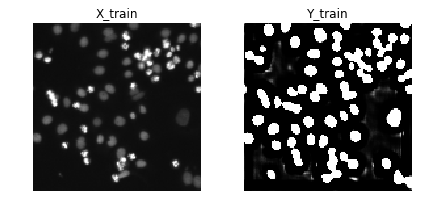

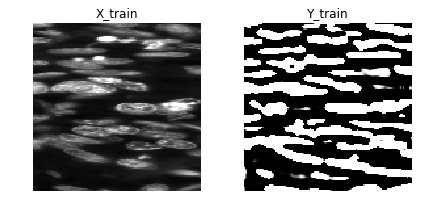

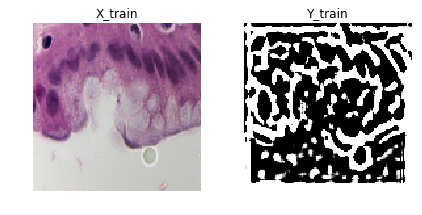

In [23]:
plotTestData(X_test, pred_y_test1)

65/65 [==============================] - ETA:  - ETA:  - 2s 35ms/step


F:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


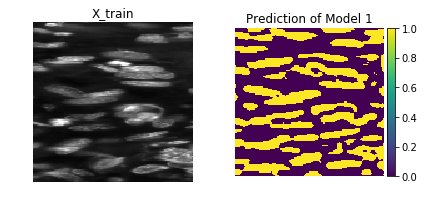

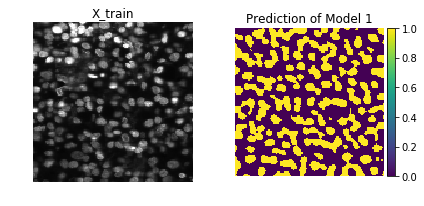

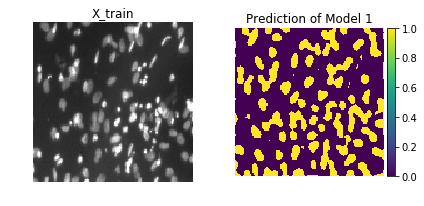

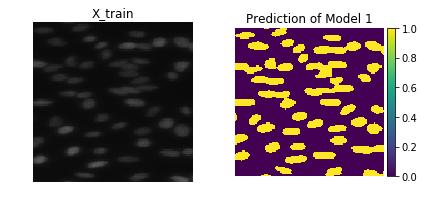

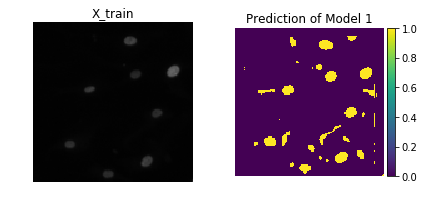

In [24]:
def plotPredictions1(a,b):
    model1 = b

    # Threshold predictions
    preds_train1 = model1.predict(a, verbose=1)
    
    preds_train_t1 = (preds_train1 > 0.5).astype(np.uint8)
    
    for i in range(0, 5):
        # Perform a sanity check on some random training samples
        ix = random.randint(0, len(preds_train_t1))
        plt.subplot(1,2,1)
        plt.title("X_train")
        plt.axis('off')
        imshow(a[ix])
        plt.subplot(1,2,2)
        plt.title("Prediction of Model 1")
        plt.axis('off')
        imshow(np.squeeze(preds_train_t1[ix]))

        plt.show()
        
plotPredictions1(X_test,modelY)

In [25]:
from IPython.display import Image
Image(url= "20171117205558592.jpg", width=600, height=600)

## <font color = blue>Evaluate Convolutional Network with U-Net Architecture

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (

280/280 [==============================] - ETA: 1:11 - loss: 0.1241 - mean_iou: 0.6437 - acc: 0.95 - ETA: 1:07 - loss: 0.1244 - mean_iou: 0.6442 - acc: 0.95 - ETA: 1:04 - loss: 0.1443 - mean_iou: 0.6446 - acc: 0.94 - ETA: 1:01 - loss: 0.1374 - mean_iou: 0.6450 - acc: 0.94 - ETA: 56s - loss: 0.1308 - mean_iou: 0.6453 - acc: 0.9481 - ETA: 51s - loss: 0.1316 - mean_iou: 0.6457 - acc: 0.948 - ETA: 47s - loss: 0.1271 - mean_iou: 0.6461 - acc: 0.950 - ETA: 43s - loss: 0.1307 - mean_iou: 0.6466 - acc: 0.948 - ETA: 38s - loss: 0.1301 - mean_iou: 0.6472 - acc: 0.948 - ETA: 34s - loss: 0.1252 - mean_iou: 0.6478 - acc: 0.950 - ETA: 29s - loss: 0.1251 - mean_iou: 0.6483 - acc: 0.950 - ETA: 25s - loss: 0.1241 - mean_iou: 0.6489 - acc: 0.950 - ETA: 20s - loss: 0.1245 - mean_iou: 0.6495 - acc: 0.950 - ETA: 16s - loss: 0.1257 - mean_iou: 0.6501 - acc: 0.950 - ETA: 11s - loss: 0.1243 - mean_iou: 0.6506 - acc: 0.951 - ETA: 6s - loss: 0.1233 - mean_iou: 0.6512 - acc: 0.951 - ETA: 2s - loss: 0.1204 - mean

280/280 [==============================] - ETA: 1:15 - loss: 0.1327 - mean_iou: 0.7670 - acc: 0.95 - ETA: 1:11 - loss: 0.1048 - mean_iou: 0.7671 - acc: 0.96 - ETA: 1:05 - loss: 0.0933 - mean_iou: 0.7672 - acc: 0.96 - ETA: 1:01 - loss: 0.0979 - mean_iou: 0.7673 - acc: 0.96 - ETA: 56s - loss: 0.1004 - mean_iou: 0.7675 - acc: 0.9639 - ETA: 52s - loss: 0.0941 - mean_iou: 0.7676 - acc: 0.966 - ETA: 47s - loss: 0.0938 - mean_iou: 0.7677 - acc: 0.966 - ETA: 43s - loss: 0.0980 - mean_iou: 0.7679 - acc: 0.963 - ETA: 38s - loss: 0.0944 - mean_iou: 0.7679 - acc: 0.965 - ETA: 33s - loss: 0.0923 - mean_iou: 0.7680 - acc: 0.965 - ETA: 29s - loss: 0.0940 - mean_iou: 0.7681 - acc: 0.965 - ETA: 24s - loss: 0.0932 - mean_iou: 0.7682 - acc: 0.965 - ETA: 20s - loss: 0.0918 - mean_iou: 0.7683 - acc: 0.965 - ETA: 15s - loss: 0.0900 - mean_iou: 0.7684 - acc: 0.966 - ETA: 11s - loss: 0.0896 - mean_iou: 0.7685 - acc: 0.966 - ETA: 6s - loss: 0.0869 - mean_iou: 0.7686 - acc: 0.967 - ETA: 2s - loss: 0.0881 - mean

280/280 [==============================] - ETA: 1:14 - loss: 0.0602 - mean_iou: 0.8047 - acc: 0.97 - ETA: 1:11 - loss: 0.0815 - mean_iou: 0.8047 - acc: 0.96 - ETA: 1:06 - loss: 0.0787 - mean_iou: 0.8047 - acc: 0.97 - ETA: 1:02 - loss: 0.0718 - mean_iou: 0.8048 - acc: 0.97 - ETA: 58s - loss: 0.0714 - mean_iou: 0.8048 - acc: 0.9727 - ETA: 53s - loss: 0.0674 - mean_iou: 0.8049 - acc: 0.974 - ETA: 48s - loss: 0.0652 - mean_iou: 0.8049 - acc: 0.975 - ETA: 43s - loss: 0.0640 - mean_iou: 0.8050 - acc: 0.975 - ETA: 39s - loss: 0.0656 - mean_iou: 0.8050 - acc: 0.974 - ETA: 34s - loss: 0.0664 - mean_iou: 0.8051 - acc: 0.974 - ETA: 29s - loss: 0.0702 - mean_iou: 0.8051 - acc: 0.972 - ETA: 25s - loss: 0.0713 - mean_iou: 0.8052 - acc: 0.971 - ETA: 20s - loss: 0.0701 - mean_iou: 0.8052 - acc: 0.972 - ETA: 16s - loss: 0.0712 - mean_iou: 0.8053 - acc: 0.972 - ETA: 11s - loss: 0.0710 - mean_iou: 0.8053 - acc: 0.972 - ETA: 6s - loss: 0.0715 - mean_iou: 0.8054 - acc: 0.971 - ETA: 2s - loss: 0.0728 - mean

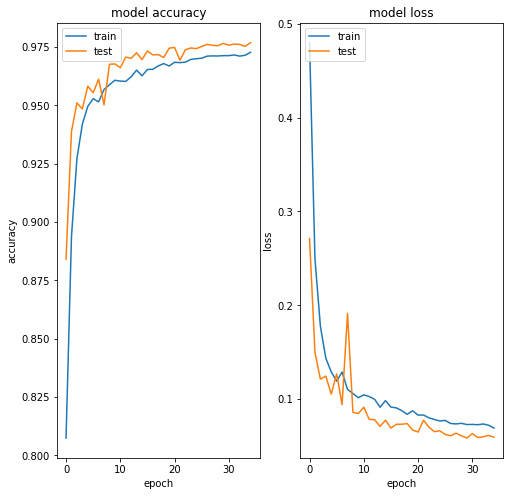

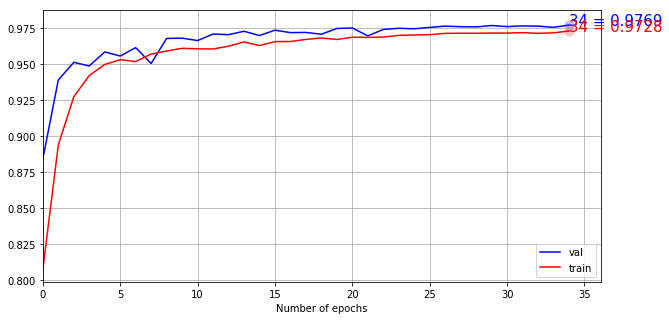

In [26]:
def UNET(a,b,c,d):
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,'accuracy'])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    # Fit model
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
    results = model.fit(a,b,batch_size=16,verbose=1,epochs=40,validation_data=(c,d),callbacks = [earlystopper, checkpointer, MetricsCheckpoint('logs')])
    plot_learning_curve(results)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    global modelZ
    modelZ = model
    return modelZ
UNET(x_train, y_train,x_test,y_test)

Conclusion:
    We can see the plot, the train curve has the accurate is 0.9728. the val curve has the accurate is 0.9769.

## <font color = blue>Display Result and Compare to Training Data

70/70 [==============================] - ETA:  - ETA:  - 7s 99ms/step


F:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


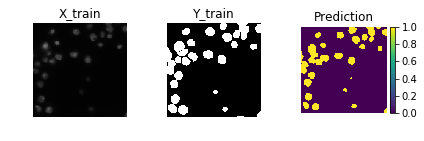

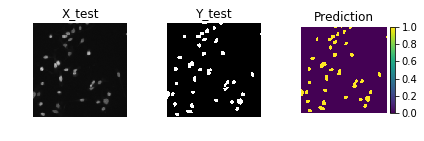

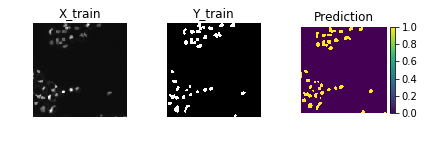

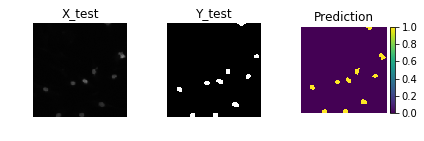

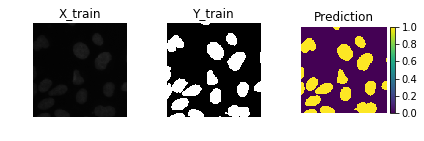

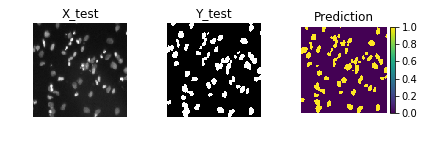

In [27]:
plotPredictions(x_train,y_train,x_test,y_test,modelZ)

70/70 [==============================] - ETA:  - ETA:  - 6s 81ms/step


F:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


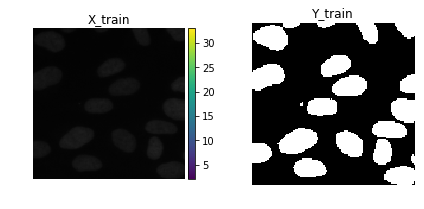

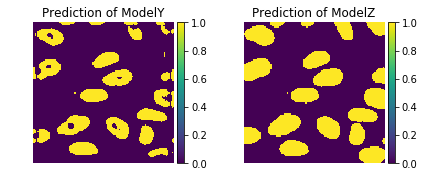

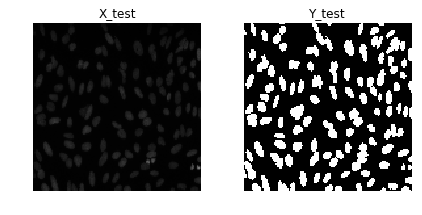

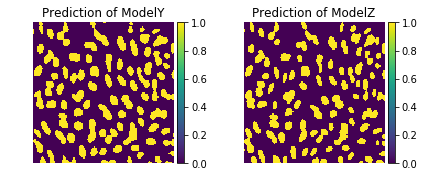

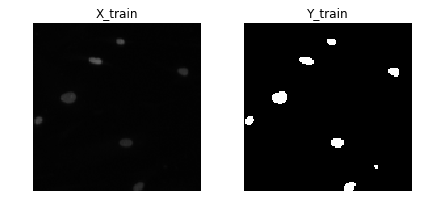

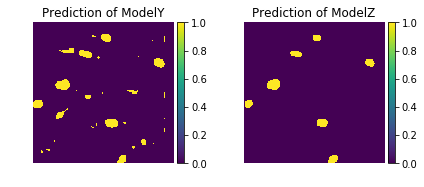

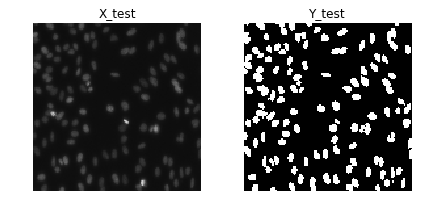

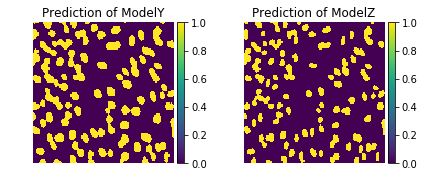

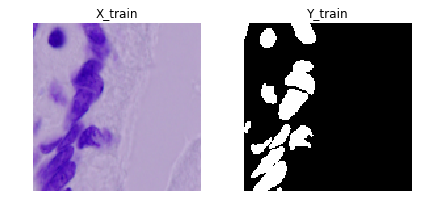

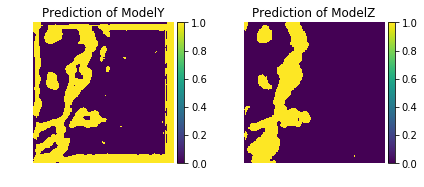

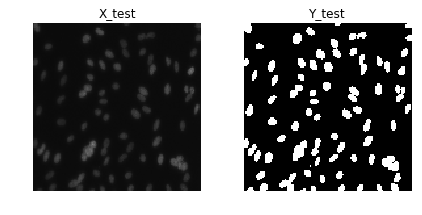

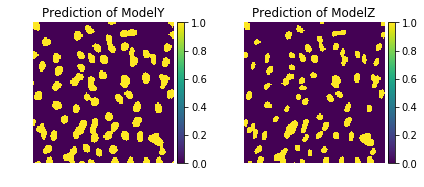

In [34]:
def plotPredictions2(a,b,c,d,e,f):
    model1 = e
    model2 = f
    # Threshold predictions
    preds_train1 = model1.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val1 = model1.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test1 = model1.predict(c, verbose=1)
    preds_train_t1 = (preds_train1 > 0.5).astype(np.uint8)
    preds_val_t1 = (preds_val1 > 0.5).astype(np.uint8)
    preds_test_t1 = (preds_test1 > 0.5).astype(np.uint8)
    
    preds_train2 = model2.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val2 = model2.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test2 = model2.predict(c, verbose=1)
    preds_train_t2 = (preds_train2 > 0.5).astype(np.uint8)
    preds_val_t2 = (preds_val2 > 0.5).astype(np.uint8)
    preds_test_t2 = (preds_test2 > 0.5).astype(np.uint8)
    
    for i in range(0, 3):
        # Perform a sanity check on some random training samples
        ix = random.randint(0, len(preds_train_t1))
        plt.subplot(1,2,1)
        plt.title("X_train")
        plt.axis('off')
        imshow(a[ix])
        plt.subplot(1,2,2)
        plt.title("Y_train")
        plt.axis('off')
        imshow(np.squeeze(b[ix]))
        plt.show()
        plt.subplot(1,2,1)
        plt.title("Prediction of ModelY")
        plt.axis('off')
        imshow(np.squeeze(preds_train_t1[ix]))
        plt.subplot(1,2,2)
        plt.title("Prediction of ModelZ")
        plt.axis('off')
        imshow(np.squeeze(preds_train_t2[ix]))
        plt.show()
        # Perform a sanity check on some random validation samples
        ix = random.randint(0, len(preds_val_t1))
        plt.subplot(1,2,1)
        plt.title("X_test")
        plt.axis('off')
        imshow(a[int(a.shape[0]*0.9):][ix])
        plt.subplot(1,2,2)
        plt.title("Y_test")
        plt.axis('off')
        imshow(np.squeeze(b[int(b.shape[0]*0.9):][ix]))
        plt.show()
        plt.subplot(1,2,1)
        plt.title("Prediction of ModelY")
        plt.axis('off')
        imshow(np.squeeze(preds_val_t1[ix]))
        plt.subplot(1,2,2)
        plt.title("Prediction of ModelZ")
        plt.axis('off')
        imshow(np.squeeze(preds_val_t2[ix]))
        plt.show()
plotPredictions2(x_train,y_train,x_test,y_test,modelY,modelZ)

In [28]:
pred_y_test2 = modelZ.predict(X_test)

## <font color = blue>Result
The results using the U-Net convolutional network are most accurate

F:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


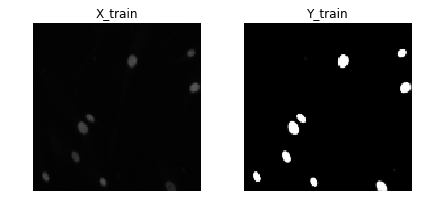

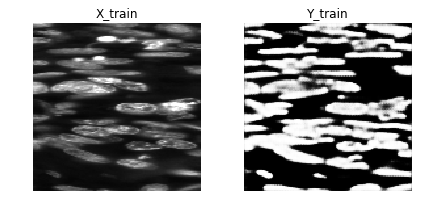

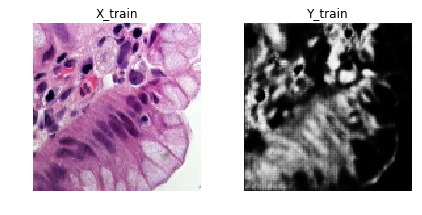

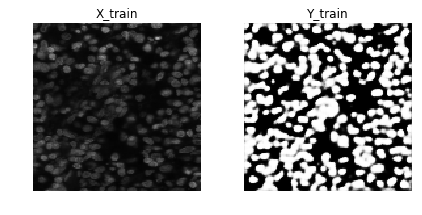

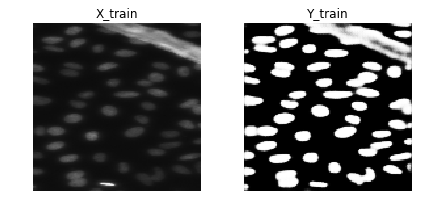

In [29]:
plotTestData(X_test, pred_y_test2)

# <font color=blue>The License

## License

[![MIT](http://nikbearbrown.com/YouTube/MachineLearning/IMG/MIT-license-sm.png)](https://opensource.org/licenses/MIT)

The MIT License (MIT)
=====================

Permission is hereby granted, free of charge, to any person
obtaining a copy of this software and associated documentation
files (the “Software”), to deal in the Software without
restriction, including without limitation the rights to use,
copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following
conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
OTHER DEALINGS IN THE SOFTWARE.